In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

In [2]:
class MyLinear1(hk.Module):

  def __init__(self, output_size, name=None):
    super().__init__(name=name)
    self.output_size = output_size

  def __call__(self, x):
    j, k = x.shape[-1], self.output_size
    w_init = hk.initializers.TruncatedNormal(1. / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    return jnp.dot(x, w) + b
  
def _forward_fn_linear1(x):
    module = MyLinear1(output_size=2)
    return module(x)

forward_linear1 = hk.transform(_forward_fn_linear1)

forward_linear1

Transformed(init=<function without_state.<locals>.init_fn at 0x0000018DAA422AC0>, apply=<function without_state.<locals>.apply_fn at 0x0000018DAA422DE0>)

In [3]:
dummy_x = jnp.array([[1., 2., 3.]])
rng_key = jax.random.PRNGKey(42)

params = forward_linear1.init(rng=rng_key, x=dummy_x)
print(params)

{'my_linear1': {'w': Array([[-0.30350363,  0.5123802 ],
       [ 0.08009142, -0.3163005 ],
       [ 0.6056666 ,  0.5820702 ]], dtype=float32), 'b': Array([1., 1.], dtype=float32)}}


In [4]:
sample_x = jnp.array([[1., 2., 3.]])
sample_x_2 = jnp.array([[4., 5., 6.], [7., 8., 9.]])

output_1 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)
# Outputs are identical for given inputs since the forward inference is non-stochastic.
output_2 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)

output_3 = forward_linear1.apply(params=params, x=sample_x_2, rng=rng_key)

print(f'Output 1 : {output_1}')
print(f'Output 2 (same as output 1): {output_2}')
print(f'Output 3 : {output_3}')

Output 1 : [[2.6736789 2.6259897]]
Output 2 (same as output 1): [[2.6736789 2.6259897]]
Output 3 : [[3.820442 4.960439]
 [4.967205 7.294889]]


In [5]:
forward_without_rng = hk.without_apply_rng(hk.transform(_forward_fn_linear1))
params = forward_without_rng.init(rng=rng_key, x=sample_x)
output = forward_without_rng.apply(x=sample_x, params=params)
print(f'Output without random key in forward pass \n {output}')

Output without random key in forward pass 
 [[2.6736789 2.6259897]]


In [6]:
#THe method used when training using gradient descent?
mutated_params = jax.tree_util.tree_map(lambda x: x+1., params) #Literally just adds one to all parameters lol
print(f'Mutated params \n : {mutated_params}')
mutated_output = forward_without_rng.apply(x=sample_x, params=mutated_params)
print(f'Output with mutated params \n {mutated_output}')

Mutated params 
 : {'my_linear1': {'b': Array([2., 2.], dtype=float32), 'w': Array([[0.69649637, 1.5123801 ],
       [1.0800915 , 0.6836995 ],
       [1.6056666 , 1.5820701 ]], dtype=float32)}}
Output with mutated params 
 [[9.673679 9.62599 ]]


In [7]:
def stateful_f(x):
  counter = hk.get_state("counter", shape=[], dtype=jnp.int32, init=jnp.ones)
  multiplier = hk.get_parameter('multiplier', shape=[1,], dtype=x.dtype, init=jnp.ones)
  hk.set_state("counter", counter + 1)
  output = x + multiplier * counter
  return output

stateful_forward = hk.without_apply_rng(hk.transform_with_state(stateful_f))
sample_x = jnp.array([[5., ]])
params, state = stateful_forward.init(x=sample_x, rng=rng_key)
print(f'Initial params:\n{params}\nInitial state:\n{state}')
print('##########')
for i in range(3):
  output, state = stateful_forward.apply(params, state, x=sample_x)
  print(f'After {i+1} iterations:\nOutput: {output}\nState: {state}')
  print('##########')

Initial params:
{'~': {'multiplier': Array([1.], dtype=float32)}}
Initial state:
{'~': {'counter': Array(1, dtype=int32)}}
##########
After 1 iterations:
Output: [[6.]]
State: {'~': {'counter': Array(2, dtype=int32)}}
##########
After 2 iterations:
Output: [[7.]]
State: {'~': {'counter': Array(3, dtype=int32)}}
##########
After 3 iterations:
Output: [[8.]]
State: {'~': {'counter': Array(4, dtype=int32)}}
##########


In [8]:
# See: https://dm-haiku.readthedocs.io/en/latest/api.html#common-modules

class MyModuleCustom(hk.Module):
    def __init__(self, output_size=2, name='custom_linear'):
        super().__init__(name=name)
        self._internal_linear_1 = hk.nets.MLP(output_sizes=[2, 3], name='hk_internal_linear')
        self._internal_linear_2 = MyLinear1(output_size=output_size, name='old_linear')

    def __call__(self, x):
        return self._internal_linear_2(self._internal_linear_1(x))

def _custom_forward_fn(x):
    module = MyModuleCustom()
    return module(x)

custom_forward_without_rng = hk.without_apply_rng(hk.transform(_custom_forward_fn))
params = custom_forward_without_rng.init(rng=rng_key, x=sample_x)
params

{'custom_linear/~/hk_internal_linear/~/linear_0': {'w': Array([[ 1.51595   , -0.23353337]], dtype=float32),
  'b': Array([0., 0.], dtype=float32)},
 'custom_linear/~/hk_internal_linear/~/linear_1': {'w': Array([[-0.22075887, -0.27375957,  0.5931483 ],
         [ 0.7818068 ,  0.72626334, -0.6860752 ]], dtype=float32),
  'b': Array([0., 0., 0.], dtype=float32)},
 'custom_linear/~/old_linear': {'w': Array([[ 0.28584382,  0.31626168],
         [ 0.2335775 , -0.4827032 ],
         [-0.14647584, -0.7185701 ]], dtype=float32),
  'b': Array([1., 1.], dtype=float32)}}

In [9]:
class HkRandom2(hk.Module):
  def __init__(self, rate=0.5):
    super().__init__()
    self.rate = rate

  def __call__(self, x):
    key1 = hk.next_rng_key()
    return jax.random.bernoulli(key1, 1.0 - self.rate, shape=x.shape)


class HkRandomNest(hk.Module):
  def __init__(self, rate=0.5):
    super().__init__()
    self.rate = rate
    self._another_random_module = HkRandom2()

  def __call__(self, x):
    key2 = hk.next_rng_key()
    p1 = self._another_random_module(x)
    p2 = jax.random.bernoulli(key2, 1.0 - self.rate, shape=x.shape)
    print(f'Bernoullis are  : {p1, p2}')

# Note that the modules that are stochastic cannot be wrapped with hk.without_apply_rng()
forward = hk.transform(lambda x: HkRandomNest()(x))

x = jnp.array(1.)
print("INIT:")
params = forward.init(rng_key, x=x)
print("APPLY:")
prediction = forward.apply(params, x=x, rng=rng_key)

INIT:
Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))
APPLY:
Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))


In [10]:
for _ in range(3):
  forward.apply(params, x=x, rng=rng_key)

Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))
Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))
Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))


In [11]:
for _ in range(3):
  rng_key, apply_rng_key = jax.random.split(rng_key)    #This is the key part to generating new rng_keys
  forward.apply(params, x=x, rng=apply_rng_key)

Bernoullis are  : (Array(False, dtype=bool), Array(False, dtype=bool))
Bernoullis are  : (Array(True, dtype=bool), Array(False, dtype=bool))
Bernoullis are  : (Array(False, dtype=bool), Array(False, dtype=bool))


In [12]:
rng_sequence = hk.PRNGSequence(rng_key) #Same principle (i think) but as an itterable
for _ in range(3):
  forward.apply(params, x=x, rng=next(rng_sequence))

Bernoullis are  : (Array(False, dtype=bool), Array(True, dtype=bool))
Bernoullis are  : (Array(False, dtype=bool), Array(False, dtype=bool))
Bernoullis are  : (Array(False, dtype=bool), Array(True, dtype=bool))


Custom simplified haiku "equivalent"

In [13]:
def my_stateless_apply(params, x):
  return params['w'] * x

In [14]:
# Global state which holds the parameters for the transformed function.
# get_param uses this to know where to get params from.
current_params = []

def transform(f):

  def apply_f(params, *args, **kwargs):
    current_params.append(params)
    outs = f(*args, **kwargs)
    current_params.pop()
    return outs

  return apply_f


def get_param(identifier):
  return current_params[-1][identifier]

In [15]:
params = dict(w=5)
my_stateless_apply(params, 5)

25

In [16]:
class MyModule:
  def apply(self, x):
    return get_param('w') * x

transform(MyModule().apply)(params, 5)

25

In [17]:
def linear(x):
  return x @ get_param('w') + get_param('b')

params = dict(w=jnp.ones((3, 5)), b=jnp.ones((5,)))
apply = transform(linear)

jax.jit(apply)(params, jnp.ones((10, 3)))

Array([[4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.]], dtype=float32)

In [18]:
from typing import NamedTuple, Dict, Callable

# Since we're tracking more than just the current params,
# we introduce the concept of a frame as the object that holds
# state during a transformed execution.
frame_stack = []

class Frame(NamedTuple):
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jax.Array]
  is_initialising: bool = False

def current_frame():
  return frame_stack[-1]


class Transformed(NamedTuple):
  init: Callable
  apply: Callable


def transform(f) -> Transformed:

  def init_f(*args, **kwargs):
    frame_stack.append(Frame({}, is_initialising=True))
    f(*args, **kwargs)
    frame = frame_stack.pop()
    return frame.params

  def apply_f(params, *args, **kwargs):
    frame_stack.append(Frame(params))
    outs = f(*args, **kwargs)
    frame_stack.pop()
    return outs

  return Transformed(init_f, apply_f)

def get_param(identifier, shape):
  if current_frame().is_initialising:
    current_frame().params[identifier] = np.random.normal(size=shape)

  return current_frame().params[identifier]

In [19]:
# Make printing parameters a little more readable
def parameter_shapes(params):
  return jax.tree_util.tree_map(lambda p: p.shape, params)


class Linear:

  def __init__(self, width):
    self._width = width

  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

init, apply = transform(Linear(4))

data = jnp.ones((2, 3))

params = init(data)
parameter_shapes(params)

{'b': (4,), 'w': (3, 4)}

In [20]:
apply(params, data)

Array([[-1.5025477,  1.1004083,  0.4648604, -1.1698687],
       [-1.5025477,  1.1004083,  0.4648604, -1.1698687]], dtype=float32)

In [21]:
import dataclasses
import collections

@dataclasses.dataclass
class Frame:
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jax.Array]
  is_initialising: bool = False

  # Keeps track of how many modules of each class have been created so far.
  # Used to assign new modules unique names.
  module_counts: Dict[str, int] = dataclasses.field(
      default_factory=lambda: collections.defaultdict(lambda: 0))

  # Keeps track of the entire path to the current module method call.
  # Module methods, when called, will add themselves to this stack.
  # Used to give each parameter a unique name corresponding to the
  # method scope it is in.
  call_stack: list = dataclasses.field(default_factory=list)

  def create_param_path(self, identifier) -> str:
    """Creates a unique path for this param."""
    return '/'.join(['~'] + self.call_stack + [identifier])

  def create_unique_module_name(self, module_name: str) -> str:
    """Assigns a unique name to the module by appending its number to its name."""
    number = self.module_counts[module_name]
    self.module_counts[module_name] += 1
    return f"{module_name}_{number}"

frame_stack = []

def current_frame():
  return frame_stack[-1]


class Module:
  def __init__(self):
    # Assign a unique (for the current `transform` call)
    # name to this instance of the module.
    self._unique_name = current_frame().create_unique_module_name(
        self.__class__.__name__)


def module_method(f):
  """A decorator for Module methods."""
  # In the real Haiku, this doesn't face the user but is applied by a metaclass.

  def wrapped(self, *args, **kwargs):
    """A version of f that lets the frame know it's being called."""
    # Self is the instance to which this method is attached.
    module_name = self._unique_name
    call_stack = current_frame().call_stack
    call_stack.append(module_name)
    call_stack.append(f.__name__)
    outs = f(self, *args, **kwargs)
    assert call_stack.pop() == f.__name__
    assert call_stack.pop() == module_name
    return outs

  return wrapped


def get_param(identifier, shape):
  frame = current_frame()
  param_path = frame.create_param_path(identifier)

  if frame.is_initialising:
    frame.params[param_path] = np.random.normal(size=shape)

  return frame.params[param_path]


class Linear(Module):

  def __init__(self, width):
    super().__init__()
    self._width = width

  @module_method  # Again, this decorator is behind-the-scenes in real Haiku.
  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

In [22]:
init, apply = transform(lambda x: Linear(4)(x))

params = init(data)
parameter_shapes(params)

{'~/Linear_0/__call__/b': (4,), '~/Linear_0/__call__/w': (3, 4)}

In [23]:
apply(params, data)

Array([[-0.9325123 ,  0.2730388 ,  2.0943596 , -0.33316752],
       [-0.9325123 ,  0.2730388 ,  2.0943596 , -0.33316752]],      dtype=float32)

In [24]:
class MLP(Module):

  def __init__(self, widths):
    super().__init__()
    self._widths = widths

  @module_method
  def __call__(self, x):
    for w in self._widths:
      out = Linear(w)(x)
      x = jax.nn.sigmoid(out)
    return out

In [25]:
init, apply = transform(lambda x: MLP([3, 5])(x))
parameter_shapes(init(data))

{'~/MLP_0/__call__/Linear_0/__call__/b': (3,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (3, 3),
 '~/MLP_0/__call__/Linear_1/__call__/b': (5,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (3, 5)}

In [26]:
class ParameterReuseTest(Module):

  @module_method
  def __call__(self, x):
    f = Linear(x.shape[-1])

    x = f(x)
    x = jax.nn.relu(x)
    return f(x)

init, forward = transform(lambda x: ParameterReuseTest()(x))
parameter_shapes(init(data))

{'~/ParameterReuseTest_0/__call__/Linear_0/__call__/b': (3,),
 '~/ParameterReuseTest_0/__call__/Linear_0/__call__/w': (3, 3)}

In [27]:
import matplotlib.pyplot as plt

In [28]:
# Data: a quadratic curve.
xs = np.linspace(-2., 2., num=128)[:, None]  # Generate array of shape (128, 1).
ys = xs ** 2

# Model
def mlp(x):
  return MLP([128, 128, 1])(x)

init, forward = transform(mlp)
params = init(xs)
parameter_shapes(params)

{'~/MLP_0/__call__/Linear_0/__call__/b': (128,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (1, 128),
 '~/MLP_0/__call__/Linear_1/__call__/b': (128,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (128, 128),
 '~/MLP_0/__call__/Linear_2/__call__/b': (1,),
 '~/MLP_0/__call__/Linear_2/__call__/w': (128, 1)}

In [29]:
# Loss function and update function
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.003

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_util.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

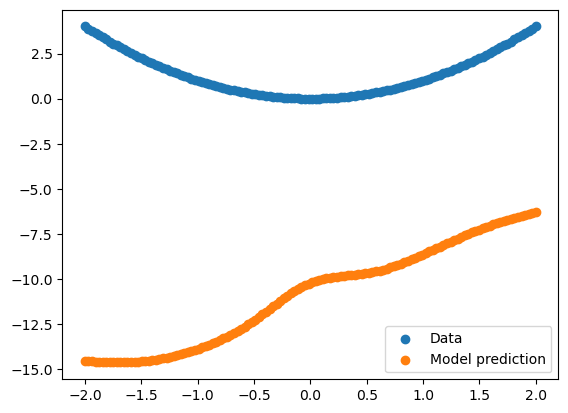

In [30]:
plt.scatter(xs, ys, label='Data')
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()
plt.show()

In [31]:
for _ in range(5000):
  params = update(params, xs, ys)

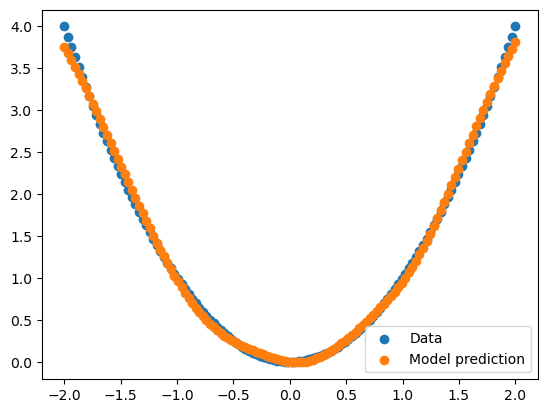

In [32]:
plt.scatter(xs, ys, label='Data')
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()
plt.show()

Training a subset of parameters

In [33]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

In [34]:
num_classes = 10

def f(x):
  return hk.nets.MLP([300, 100, num_classes])(x)

f = hk.transform(f)

def test(params, num_classes=num_classes):
  x = np.arange(num_classes).reshape([num_classes, 1]).astype(np.float32)
  y = jnp.argmax(f.apply(params, None, x), axis=-1)
  for x, y in zip(x, y):
    print(x, "->", y)

rng = jax.random.PRNGKey(42)
x = np.zeros([num_classes, 1])
params = f.init(rng, x)

print(parameter_shapes(params))
print("before training")
test(params)

c:\Users\00tho\anaconda3\envs\RASP\Lib\site-packages\haiku\_src\initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
c:\Users\00tho\anaconda3\envs\RASP\Lib\site-packages\haiku\_src\base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


{'mlp/~/linear_0': {'b': (300,), 'w': (1, 300)}, 'mlp/~/linear_1': {'b': (100,), 'w': (300, 100)}, 'mlp/~/linear_2': {'b': (10,), 'w': (100, 10)}}
before training
[0.] -> 0
[1.] -> 3
[2.] -> 3
[3.] -> 3
[4.] -> 3
[5.] -> 3
[6.] -> 3
[7.] -> 3
[8.] -> 3
[9.] -> 3


In [35]:
def dataset(*, batch_size, num_records):
  for _ in range(num_records):
    y = np.arange(num_classes)
    y = np.random.permutation(y)[:batch_size]
    x = y.reshape([batch_size, 1]).astype(np.float32)
    yield x, y

for x, y in dataset(batch_size=4, num_records=5):
  print("x :=", x.tolist(), "y :=", y)

x := [[3.0], [0.0], [6.0], [4.0]] y := [3 0 6 4]
x := [[3.0], [9.0], [1.0], [4.0]] y := [3 9 1 4]
x := [[1.0], [5.0], [4.0], [9.0]] y := [1 5 4 9]
x := [[1.0], [2.0], [7.0], [4.0]] y := [1 2 7 4]
x := [[8.0], [9.0], [3.0], [4.0]] y := [8 9 3 4]


In [36]:
# Partition our params into trainable and non trainable explicitly.
trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda m, n, p: m != "mlp/~/linear_1", params)

print("trainable:", list(trainable_params))
print("non_trainable:", list(non_trainable_params))
trainable_params = params
print("trainable:", list(trainable_params))

trainable: ['mlp/~/linear_0', 'mlp/~/linear_2']
non_trainable: ['mlp/~/linear_1']
trainable: ['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2']


In [37]:
def loss_fn(trainable_params, non_trainable_params, images, labels):
  # NOTE: We need to combine trainable and non trainable before calling apply.
  params = hk.data_structures.merge(trainable_params, non_trainable_params)

  # NOTE: From here on this is a standard softmax cross entropy loss.
  logits = f.apply(params, None, images)
  labels = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(labels * jax.nn.log_softmax(logits)) / labels.shape[0]

def sgd_step(params, grads, *, lr):
  return jax.tree_util.tree_map(lambda p, g: p - g * lr, params, grads)

def train_step(trainable_params, non_trainable_params, x, y):
  # NOTE: We will only compute gradients wrt `trainable_params`.
  trainable_params_grads = jax.grad(loss_fn)(trainable_params,
                                             non_trainable_params, x, y)

  # NOTE: We are only updating `trainable_params`.
  trainable_params = sgd_step(trainable_params, trainable_params_grads, lr=0.1)
  return trainable_params

train_step = jax.jit(train_step)

for x, y in dataset(batch_size=num_classes, num_records=10000):
  # NOTE: In our training loop only our trainable parameters are updated.
  trainable_params = train_step(trainable_params, non_trainable_params, x, y)

In [38]:
# Merge params again for inference.
params = hk.data_structures.merge(trainable_params, non_trainable_params)

print("after training")
test(params)

after training
[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9


In [39]:
test(params, num_classes=num_classes+10)

[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9
[10.] -> 9
[11.] -> 9
[12.] -> 9
[13.] -> 9
[14.] -> 9
[15.] -> 9
[16.] -> 9
[17.] -> 9
[18.] -> 9
[19.] -> 9
